In [647]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from transformers import AutoTokenizer, AutoModel
import umap
from sklearn.manifold import trustworthiness
import hdbscan

import torch
import torch.nn as nn
from tqdm import tqdm

import spacy
from datasets import Dataset

import warnings
warnings.filterwarnings('ignore')

In [648]:
df = pd.read_csv('preprocessed.csv', encoding = 'utf-32',sep='\t')

In [649]:
df.drop('Unnamed: 0', inplace=True, axis=1)
df.drop('index', inplace=True, axis=1)

In [650]:
df=df.dropna().reset_index(drop=True)

<b>Creating Embeddings</b>

In [651]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [652]:
class model(nn.Module):
    def __init__(self,checkpoint,freeze=False,device='cpu'):
        super().__init__()

        self.model=AutoModel.from_pretrained(checkpoint)
        hidden_sz=self.model.config.hidden_size

        self.device=device

        if freeze:
            for layer in self.model.parameters():
                layer.requires_grad=False
    
    def forward(self,x,attention_mask=None):
        x=x.to(self.device)

        with torch.no_grad():
            model_out=self.model(**x)
        
        embds=model_out.last_hidden_state
        mean_pool=torch.mean(embds, dim=1)
        return mean_pool

In [653]:
checkpoint='lighteternal/gpt2-finetuned-greek'
bert=model(checkpoint,freeze=True,device=device)
bert.to(device)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Some weights of the model checkpoint at lighteternal/gpt2-finetuned-greek were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [654]:
final_embeddings=list()
all_embeddings=[]

final_sentences=[]
for message in df['final_sentences']:
    final_sentences.append(message)

In [655]:
batch_sz = 256
for idx in tqdm(range(0, len(final_sentences), batch_sz)):
    batch_sentences = final_sentences[idx:idx+batch_sz]
    for sent in batch_sentences:
        tokens = tokenizer(sent ,truncation=True,max_length=1024, return_tensors='pt', return_attention_mask=True,padding=True)
        embeddings = bert(tokens)
        final_embeddings.extend(embeddings)
        all_embeddings = torch.stack(final_embeddings)

100%|██████████| 53/53 [10:18<00:00, 11.66s/it]


In [656]:
if device.type=='cuda':
    cpu_embeddings=all_embeddings.cpu()
else:
    cpu_embeddings=all_embeddings

<b>UMAP Dimensionality Reduction</b>

In [657]:
n_neighbors=15
n_components=5

In [658]:
fit=umap.UMAP(n_components=n_components,n_neighbors=n_neighbors,min_dist=0,metric='cosine',random_state=1234)
reduced_embds=fit.fit_transform(cpu_embeddings)

In [659]:
tw = trustworthiness(cpu_embeddings, reduced_embds, n_neighbors=n_neighbors)
print("Trustworthiness:", round(tw, 4))

Trustworthiness: 0.9818


In [660]:
if n_components==2:
    sns.scatterplot(x=reduced_embds[:,0],y=reduced_embds[:,1])

<b>HDBScan Hyperparameter Tuning</b>

In [661]:
def funk(df, method, list_name):
    global data_leaf, data_eom
    n = df.shape[0]
    for gamma in range (1, int(np.log(n))):
        for ms in range(1, int(2 * np.log(n))):
            clust_alg = hdbscan.HDBSCAN(algorithm='best', alpha=1.0,
                                    approx_min_span_tree=True,
                                    gen_min_span_tree=True, 
                                    leaf_size=40,
                                    cluster_selection_method=method,
                                    metric='euclidean', 
                                    min_cluster_size=int(gamma * np.sqrt(n)), 
                                    min_samples=ms,
                                    allow_single_cluster=False).fit(df)
 
            min_cluster_size = clust_alg.min_cluster_size 
            min_samples = clust_alg.min_samples
            validity_score = clust_alg.relative_validity_
            n_clusters = np.max(clust_alg.labels_) 
            list_name.append((min_cluster_size, min_samples, validity_score, n_clusters))
            if validity_score >= .5:
                print (f'min_cluster_size = {min_cluster_size},  min_samples = {min_samples}, validity_score = {validity_score} n_clusters = {n_clusters}')

def best_validity(source):
    cols = ['min_cluster_size', 'min_samples', 'validity_score', 'n_clusters']
    df =  pd.DataFrame(source, columns = cols)
    best_validity = df.loc[df['validity_score'].idxmax()]
    return best_validity


data_eom = []

In [662]:
funk(df = reduced_embds, method = 'eom', list_name = data_eom)
best_eom = best_validity(data_eom)
best_eom

min_cluster_size    115.000000
min_samples           1.000000
validity_score        0.456792
n_clusters           19.000000
Name: 0, dtype: float64

In [663]:
clust_alg_eom = hdbscan.HDBSCAN(algorithm='best', alpha=1.0,
                            approx_min_span_tree=True,
                            gen_min_span_tree=True, 
                            leaf_size=40,
                            cluster_selection_method='eom',
                            metric='euclidean', 
                            min_cluster_size=int(best_eom['min_cluster_size']), 
                            min_samples=int(best_eom['min_samples']), 
                            allow_single_cluster=False).fit(reduced_embds) 

<b>HDBScan Clustering</b>

<Axes: ylabel='$\\lambda$ value'>

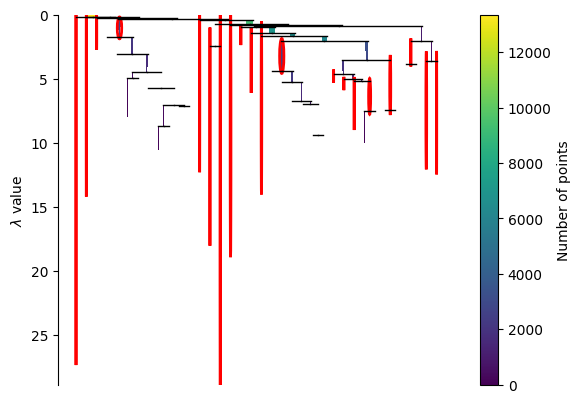

In [664]:
clust_alg_eom.condensed_tree_.plot(select_clusters=True)

In [665]:
df['Bert_Labels']=clust_alg_eom.labels_

In [666]:
df.Bert_Labels.value_counts()

 3     2872
 14    2769
-1     1704
 19    1326
 15     658
 7      518
 11     509
 13     377
 6      314
 10     308
 9      260
 0      215
 5      213
 4      193
 12     178
 1      176
 2      163
 17     163
 18     161
 16     139
 8      137
Name: Bert_Labels, dtype: int64

<b>C-TF-IDF</b>

In [667]:
classes = {}
for label in set(clust_alg_eom.labels_):
    classes[label] = {
        'vocab': set(),
        'tokens': [],
        'tfidf_array': None
    }

In [668]:
nlp = spacy.load("el_core_news_lg")

In [669]:
data = Dataset.from_pandas(df)

In [670]:
def tokenize(doc):
    return [token.text for token in doc]

In [671]:
data = data.map(lambda x: {
    'tokens': tokenize(nlp(x['final_sentences']))
})

Map:   0%|          | 0/13353 [00:00<?, ? examples/s]

In [672]:
for row in data:
    classes[row['Bert_Labels']]['tokens'].extend(row['tokens'])

In [673]:
for c in classes.keys():
    print(f"{c}: {len(classes[c]['tokens'])}")

0: 69251
1: 9231
2: 53051
3: 160193
4: 50204
5: 124680
6: 213519
7: 56441
8: 3312
9: 14775
10: 12069
11: 98089
12: 11402
13: 80400
14: 373443
15: 75844
16: 15895
17: 13594
18: 30874
19: 161338
-1: 245911


In [674]:
vocab = set()
for c in classes.keys():
    vocab = vocab.union(set(classes[c]['tokens']))
    classes[c]['vocab'] = set(classes[c]['tokens'])

In [675]:
tf = np.zeros((len(classes.keys()), len(vocab)))

for c, _class in enumerate(classes.keys()):
    for t, term in enumerate(tqdm(vocab)):
        tf[c, t] = classes[_class]['tokens'].count(term)

100%|██████████| 100750/100750 [10:19<00:00, 162.74it/s]


In [676]:
idf = np.zeros((1, len(vocab)))

A = tf.sum() / tf.shape[0]

for t, term in enumerate(tqdm(vocab)):
    f_t = tf[:,t].sum()
    idf_score = np.log(1 + (A / f_t))
    idf[0, t] = idf_score

100%|██████████| 100750/100750 [00:00<00:00, 188642.23it/s]


In [677]:
tf_idf = tf*idf

In [678]:
n = 20
top_idx = np.argpartition(tf_idf, -n)[:, -n:]

In [679]:
vlist = list(vocab)

for c, _class in enumerate(classes.keys()):
    topn_idx = top_idx[c, :]
    topn_terms = [vlist[idx] for idx in topn_idx]
    print(_class,topn_terms)

0 ['ος', 'πρακτικός', 'συνεδρίαση', 'συγκρότηση', 'έργο', 'αρ', 'διενέργειας', 'ηλεκτρονικός', 'κάτω', 'έτος', 'άνω', 'ανοικτής', 'αξιολόγηση', 'διαδικασίας', 'προμήθεια', 'σύμβαση', 'διακ', 'σύναψης', 'ορίων', 'έγκριση']
1 ['προγραμματισμού', 'δικτύω', 'ζεύγος', 'τεχνικών', 'ηλεκτροδότησης', 'τάση', 'ρευματοφόροι', 'γιαννόπουλος', 'διευθυνσηλειτουργιας', 'ενημερώνω', 'εγώ', 'εγκαταστασεων', 'διακοπή', 'υποσταθμός', 'συντηρησης', 'διακοπή', 'προϊστάμενος', 'κτίρια', 'κτίριο', 'ηλεκτροδότηση']
2 ['ἔχω', 'θὰ', 'καί', 'στὴν', 'οἱ', 'ὅτι', 'νὰ', 'τὰ', 'εἶμαι', 'ποὺ', 'τῆς', 'καὶ', 'τὴν', 'μὲ', 'τῶν', 'τοῦ', 'γιὰ', 'σὲ', 'ἀπὸ', 'δὲν']
3 ['ιατρικής', 'πραγματοποιώ', 'διπλωματικής', 'εργασίας', 'μεταπτυχιακής', 'πλαίσιο', 'μεταπτυχιακός', 'παρουσίαση', 'καθηγήτρια', 'εργασία', 'τριμελής', 'ανακοινωση', 'τηλεδιάσκεψη', 'διπλωματικής', 'δημόσιος', 'επιβλέπων', 'παρουσίαση', 'γίνομαι', 'δημόσια', 'αίθουσα']
4 ['μηχανικός', 'επιλογή', 'αντίγραφο', 'γίνομαι', 'υποψήφιος', 'μεταπτυχιακός'

In [680]:
name_mapping = {
    0: 'Ανακοινωσεις προς ΔΕΠ',   #ημερησια διαταξη
    1: 'Διακοπη Υπηρεσιων',   #ρευματος
    2: 'Γενικα',   #καθαρευουσα
    3: 'Παρουσιασεις/Ομηλιες/Σεμιναρεια',   #παρουσιαση μεαπτυχιακων/διατριβων
    4: 'Ανακοινωσεις νεων μεταπτυχιακων/διδακτορικων προγραμματων',
    5: 'Πολιτικα/Συναισθηματικα φορτισμενα μηνυματα/συζητησεις',  
    6: 'Ανακοινωσεις προς ΔΕΠ', #δελτιο τυπου
    7: 'Ανακοινωσεις προς ΔΕΠ',    
    8: 'Γενικα',     #χαμενα αντικειμενα
    9: 'Ανακοινωσεις προς ΔΕΠ',  ##εκλογες
    10:'Παρουσιασεις/Ομηλιες/Σεμιναρεια',    #παρουσιασεις/ομηλιες βιβλιων,αρθρων κλπ
    11:'Ανακοινωσεις προς ΔΕΠ',    
    12:'Ανακοινωσεις προς ΔΕΠ',    #ανακοινωσεις κοσμητειας σχολης
    13:'Παρουσιασεις/Ομηλιες/Σεμιναρεια',  #διδακτορικες διατριβες
    14:'Πολιτικα/Συναισθηματικα φορτισμενα μηνυματα/συζητησεις',    
    15:'Εκδηλωσεις', 
    16:'Παρουσιασεις/Ομηλιες/Σεμιναρεια',   
    17:'Διακοπη Υπηρεσιων', 
    18:'Παρουσιασεις/Ομηλιες/Σεμιναρεια',  #σεμηναρεια
    19:'19',
    -1:'-1' 
}

In [681]:
df['Bert_Labels'] = df['Bert_Labels'].replace(name_mapping)

<b>Clustering Ambiguous Categories</b>

19

In [682]:
searcher1=df.loc[df['Bert_Labels']=='19' ].reset_index(drop=True)

In [683]:
final_embeddings=list()
all_embeddings=[]

final_sentences=[]
for message in searcher1['final_sentences']:
    final_sentences.append(message)

In [684]:
batch_sz = 256
for idx in tqdm(range(0, len(final_sentences), batch_sz)):
    batch_sentences = final_sentences[idx:idx+batch_sz]
    for sent in batch_sentences:
        tokens = tokenizer(sent ,truncation=True,max_length=512, return_tensors='pt', return_attention_mask=True,padding=True)
        embeddings = bert(tokens)
        final_embeddings.extend(embeddings)
        all_embeddings = torch.stack(final_embeddings)

100%|██████████| 6/6 [01:13<00:00, 12.32s/it]


In [685]:
if device.type=='cuda':
    cpu_embeddings=all_embeddings.cpu()
else:
    cpu_embeddings=all_embeddings

<b>UMAP Dimensionality Reduction</b>

In [686]:
n_neighbors=10

In [687]:
fit=umap.UMAP(n_components=5,n_neighbors=n_neighbors,min_dist=0,metric='cosine',random_state=1234)
reduced_embds=fit.fit_transform(cpu_embeddings)

In [688]:
tw = trustworthiness(cpu_embeddings, reduced_embds, n_neighbors=n_neighbors)
print("Trustworthiness:", round(tw, 3))

Trustworthiness: 0.944


<b>HDBScan Hyperparameter Tuning</b>

In [689]:
funk(df = reduced_embds, method = 'eom', list_name = data_eom)
best_eom = best_validity(data_eom)
best_eom

min_cluster_size    115.000000
min_samples           1.000000
validity_score        0.456792
n_clusters           19.000000
Name: 0, dtype: float64

In [690]:
clust_alg_eom = hdbscan.HDBSCAN(algorithm='best', alpha=1.0,
                            approx_min_span_tree=True,
                            gen_min_span_tree=True, 
                            leaf_size=40,
                            cluster_selection_method='eom',
                            metric='euclidean', 
                            min_cluster_size=int(best_eom['min_cluster_size']), 
                            min_samples=int(best_eom['min_samples']), 
                            allow_single_cluster=False).fit(reduced_embds)

<b>HDBScan Clustering</b>

<Axes: ylabel='$\\lambda$ value'>

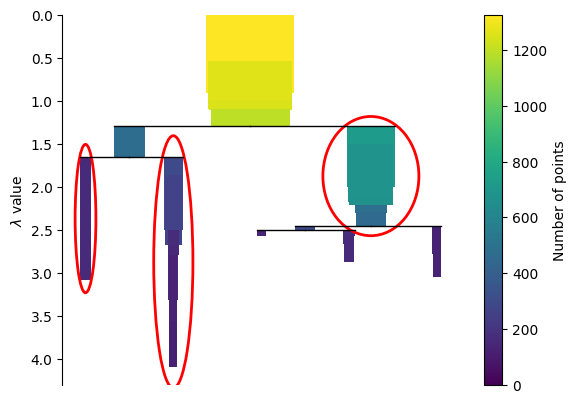

In [691]:
clust_alg_eom.condensed_tree_.plot(select_clusters=True)

In [692]:
searcher1['Bert_Labels2']=clust_alg_eom.labels_

In [693]:
searcher1.Bert_Labels2.value_counts()

 0    725
 2    296
 1    157
-1    148
Name: Bert_Labels2, dtype: int64

In [694]:
name_mapping = {
    0: 'Εκδηλωσεις',   
    1: 'Ανακοινωσεις προς ΔΕΠ',   #ΜΟΔΥ ΕΛΚΕ
    2: 'Ανακοινωσεις προς ΔΕΠ',   #ΜΟΔΥ ΕΛΚΕ
    -1:'Εκδηλωσεις' 
}

In [695]:
searcher1['Bert_Labels2'] = searcher1['Bert_Labels2'].replace(name_mapping)

In [696]:
for i in range(df.shape[0]):
    for j in range(searcher1.shape[0]):
        if df['Author'][i]==searcher1['Author'][j] and df['Date'][i]==searcher1['Date'][j] and df['To'][i]==searcher1['To'][j] and df['Subject'][i]==searcher1['Subject'][j] and df['Message'][i]==searcher1['Message'][j] and df['final_sentences'][i]==searcher1['final_sentences'][j] and df['Bert_Labels'][i]==searcher1['Bert_Labels'][j]:
            df.at[i,'Bert_Labels']=searcher1['Bert_Labels2'][j]

-1

In [697]:
searcher2=df.loc[df['Bert_Labels']=='-1' ].reset_index(drop=True)

In [698]:
final_embeddings=list()
all_embeddings=[]

final_sentences=[]
for message in searcher2['final_sentences']:
    final_sentences.append(message)

In [699]:
batch_sz = 256
for idx in tqdm(range(0, len(final_sentences), batch_sz)):
    batch_sentences = final_sentences[idx:idx+batch_sz]
    for sent in batch_sentences:
        tokens = tokenizer(sent ,truncation=True,max_length=512, return_tensors='pt', return_attention_mask=True,padding=True)
        embeddings = bert(tokens)
        final_embeddings.extend(embeddings)
        all_embeddings = torch.stack(final_embeddings)

100%|██████████| 7/7 [01:33<00:00, 13.33s/it]


In [700]:
if device.type=='cuda':
    cpu_embeddings=all_embeddings.cpu()
else:
    cpu_embeddings=all_embeddings

<b>UMAP Dimensionality Reduction</b>

In [701]:
n_neighbors=15

In [702]:
fit=umap.UMAP(n_components=5,n_neighbors=n_neighbors,min_dist=0,metric='cosine',random_state=1234)
reduced_embds=fit.fit_transform(cpu_embeddings)

In [703]:
tw = trustworthiness(cpu_embeddings, reduced_embds, n_neighbors=n_neighbors)
print("Trustworthiness:", round(tw, 3))

Trustworthiness: 0.968


<b>HDBScan Hyperparameter Tuning</b>

In [704]:
funk(df = reduced_embds, method = 'eom', list_name = data_eom)
best_eom = best_validity(data_eom)
best_eom

min_cluster_size = 41,  min_samples = 5, validity_score = 0.5004979669364542 n_clusters = 18
min_cluster_size = 41,  min_samples = 8, validity_score = 0.5166479333468377 n_clusters = 17
min_cluster_size = 41,  min_samples = 9, validity_score = 0.5127846450612867 n_clusters = 17


min_cluster_size    41.000000
min_samples          8.000000
validity_score       0.516648
n_clusters          17.000000
Name: 221, dtype: float64

In [705]:
clust_alg_eom = hdbscan.HDBSCAN(algorithm='best', alpha=1.0,
                            approx_min_span_tree=True,
                            gen_min_span_tree=True, 
                            leaf_size=40,
                            cluster_selection_method='eom',
                            metric='euclidean', 
                            min_cluster_size=int(best_eom['min_cluster_size']), 
                            min_samples=int(best_eom['min_samples']), 
                            allow_single_cluster=False).fit(reduced_embds)

<b>HDBScan Clustering</b>

<Axes: ylabel='$\\lambda$ value'>

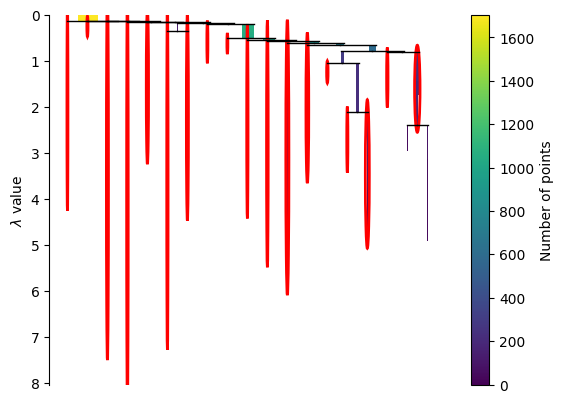

In [706]:
clust_alg_eom.condensed_tree_.plot(select_clusters=True)

In [707]:
searcher2['Bert_Labels2']=clust_alg_eom.labels_

In [708]:
searcher2.Bert_Labels2.value_counts()

 15    232
-1     181
 17    170
 11    132
 12    120
 4      97
 2      88
 6      88
 10     70
 3      67
 13     61
 14     59
 9      57
 5      57
 1      49
 16     48
 7      44
 0      43
 8      41
Name: Bert_Labels2, dtype: int64

In [709]:
name_mapping = {
    0: 'Ανακοινωσεις προς ΔΕΠ',   
    1: 'Ανακοινωσεις προς ΔΕΠ',   
    2: 'Γενικα',   ##αθλητικα
    3: 'Διακοπη Υπηρεσιων',   
    4: 'Ανακοινωσεις νεων μεταπτυχιακων/διδακτορικων προγραμματων',  
    5: 'Ανακοινωσεις προς ΔΕΠ', 
    6: 'Ανακοινωσεις προς ΔΕΠ', 
    7: 'Παρουσιασεις/Ομηλιες/Σεμιναρεια',     
    8: 'Εκδηλωσεις',     
    9: 'Ανακοινωσεις προς ΔΕΠ', 
    10:'Παρουσιασεις/Ομηλιες/Σεμιναρεια',    
    11:'Εκδηλωσεις',    
    12:'Εκδηλωσεις',    
    13:'Εκδηλωσεις',  
    14:'Εκδηλωσεις',  
    15:'Παρουσιασεις/Ομηλιες/Σεμιναρεια',  
    16:'Παρουσιασεις/Ομηλιες/Σεμιναρεια',  
    17:'Γενικα',  
    -1:'Εκδηλωσεις' 
}

In [710]:
searcher2['Bert_Labels2'] = searcher2['Bert_Labels2'].replace(name_mapping)

In [711]:
for i in range(df.shape[0]):
    for j in range(searcher2.shape[0]):
        if df['Author'][i]==searcher2['Author'][j] and df['Date'][i]==searcher2['Date'][j] and df['To'][i]==searcher2['To'][j] and df['Subject'][i]==searcher2['Subject'][j] and df['Message'][i]==searcher2['Message'][j] and df['final_sentences'][i]==searcher2['final_sentences'][j] and df['Bert_Labels'][i]==searcher2['Bert_Labels'][j]:
            df.at[i,'Bert_Labels']=searcher2['Bert_Labels2'][j]

In [712]:
df.Bert_Labels.value_counts()

Παρουσιασεις/Ομηλιες/Σεμιναρεια                              4251
Πολιτικα/Συναισθηματικα φορτισμενα μηνυματα/συζητησεις       2982
Ανακοινωσεις προς ΔΕΠ                                        2741
Εκδηλωσεις                                                   2125
Γενικα                                                        558
Διακοπη Υπηρεσιων                                             406
Ανακοινωσεις νεων μεταπτυχιακων/διδακτορικων προγραμματων     290
Name: Bert_Labels, dtype: int64

<b>Visualization</b>

In [714]:
df['Date_only']=df['Date']

In [715]:
for i in range(len(df['Date'])):
    df['Date_only'][i]=df['Date'][i][1:11]

In [716]:
df['Date_only'][10688]='2022-07-11'

In [717]:
df['Date_only']=pd.to_datetime(df['Date_only'])

In [718]:
df['Month'] = df['Date_only'].dt.to_period('M')

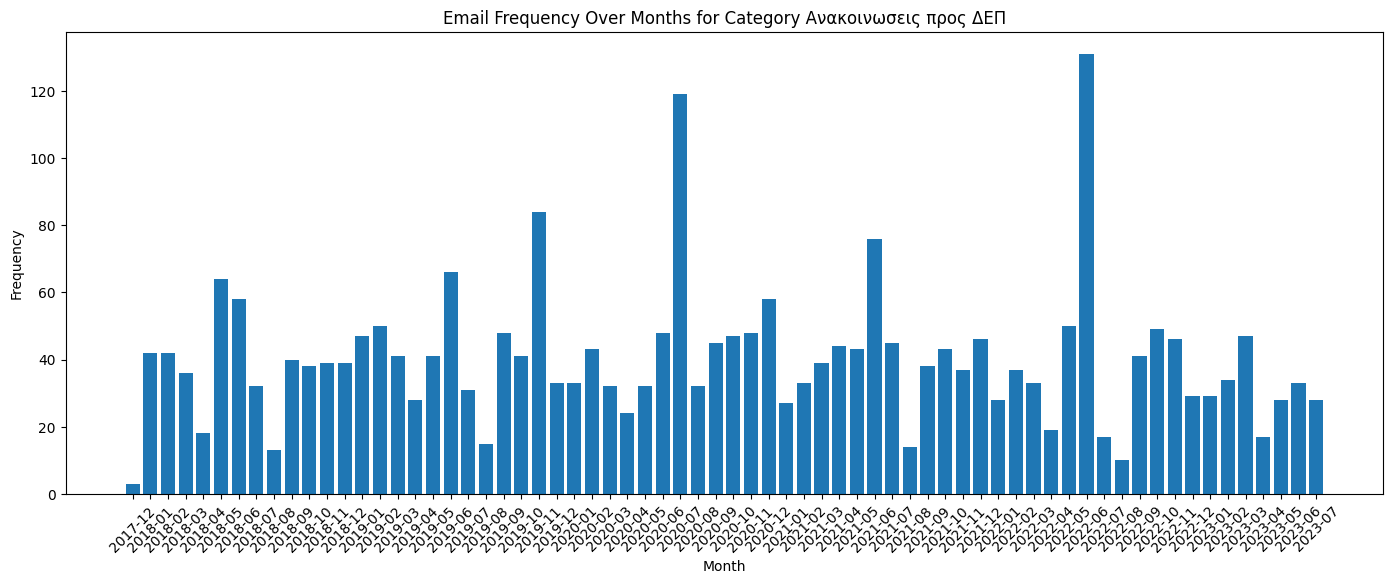

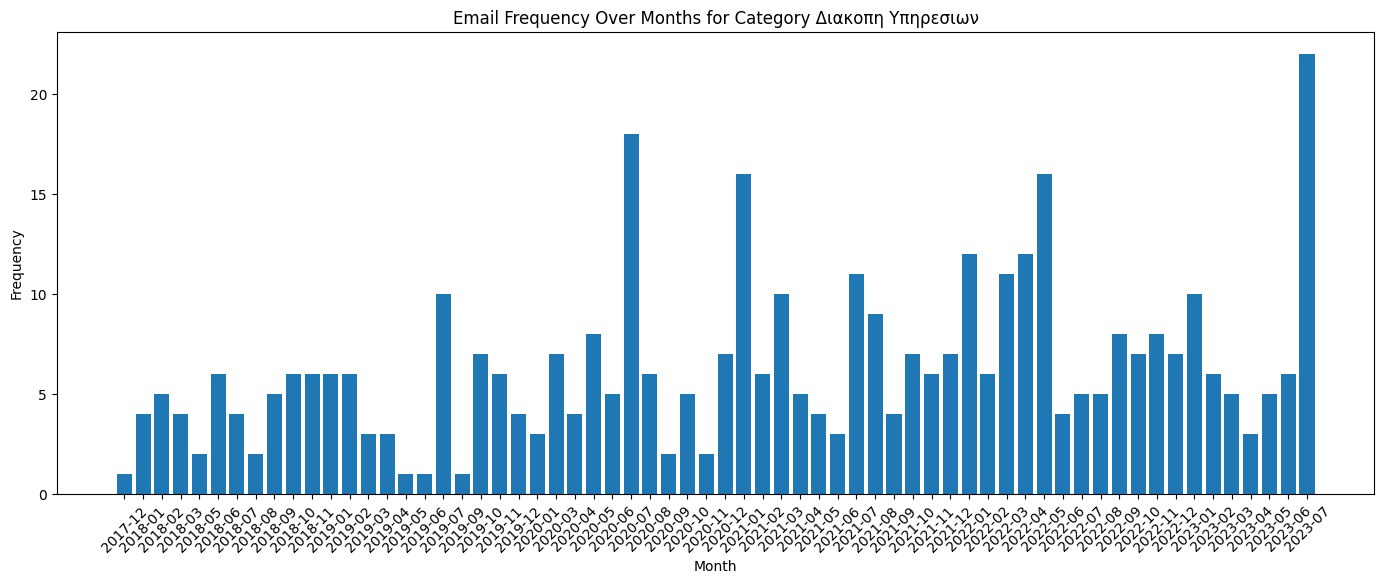

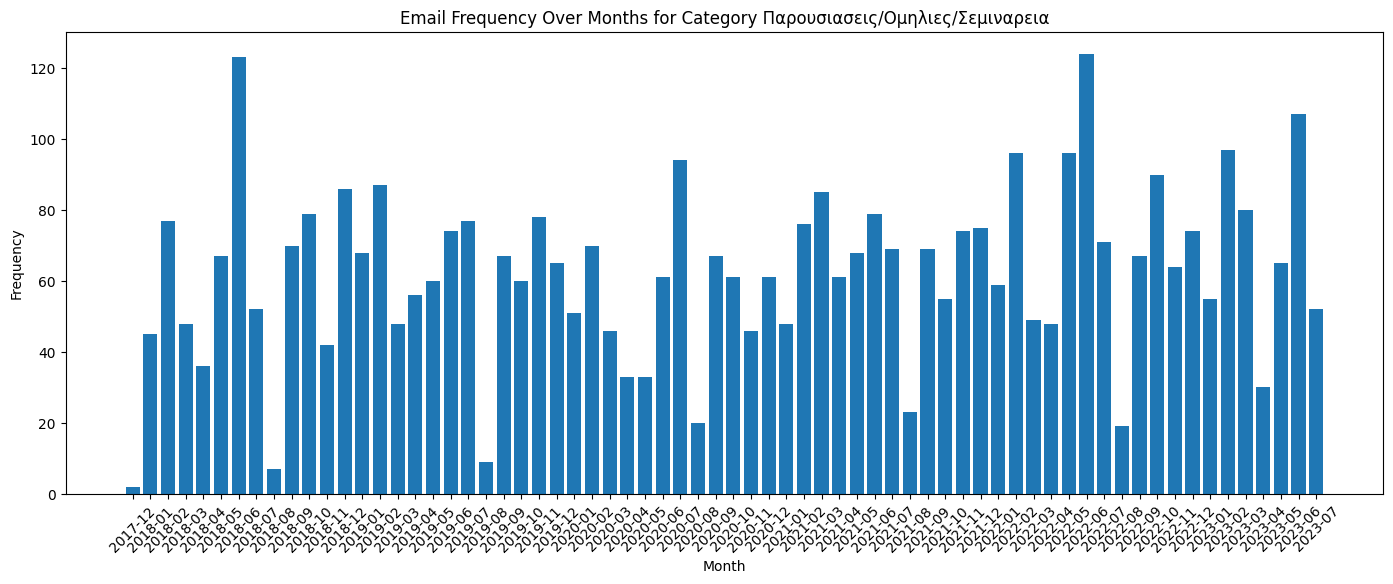

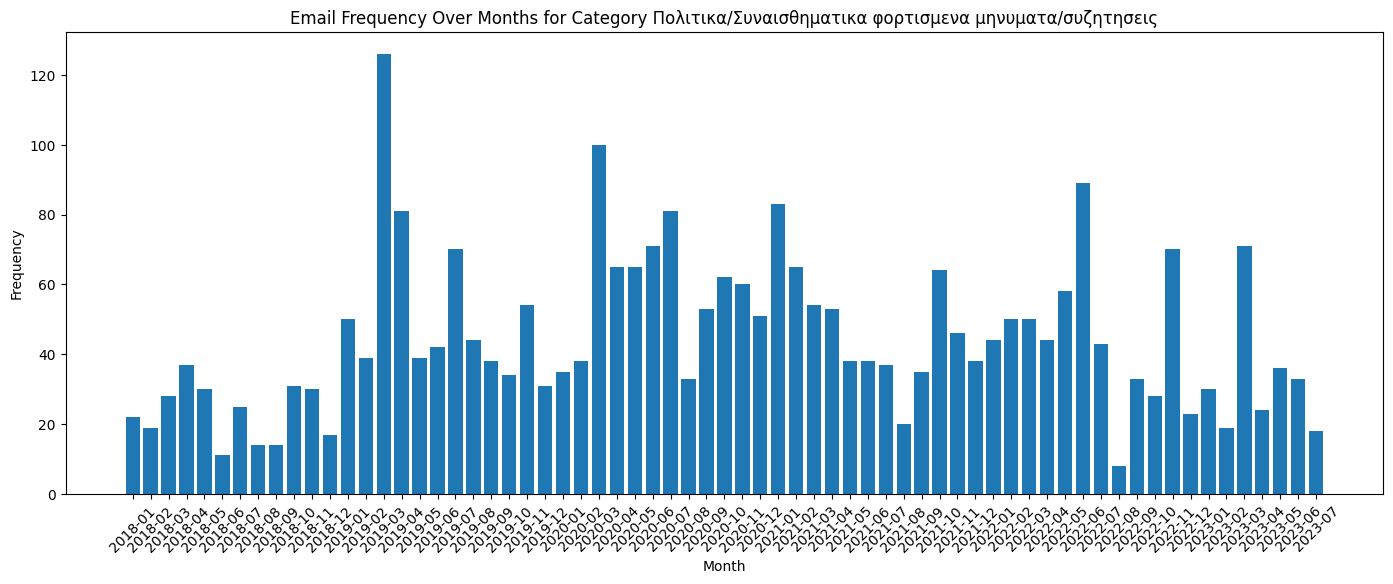

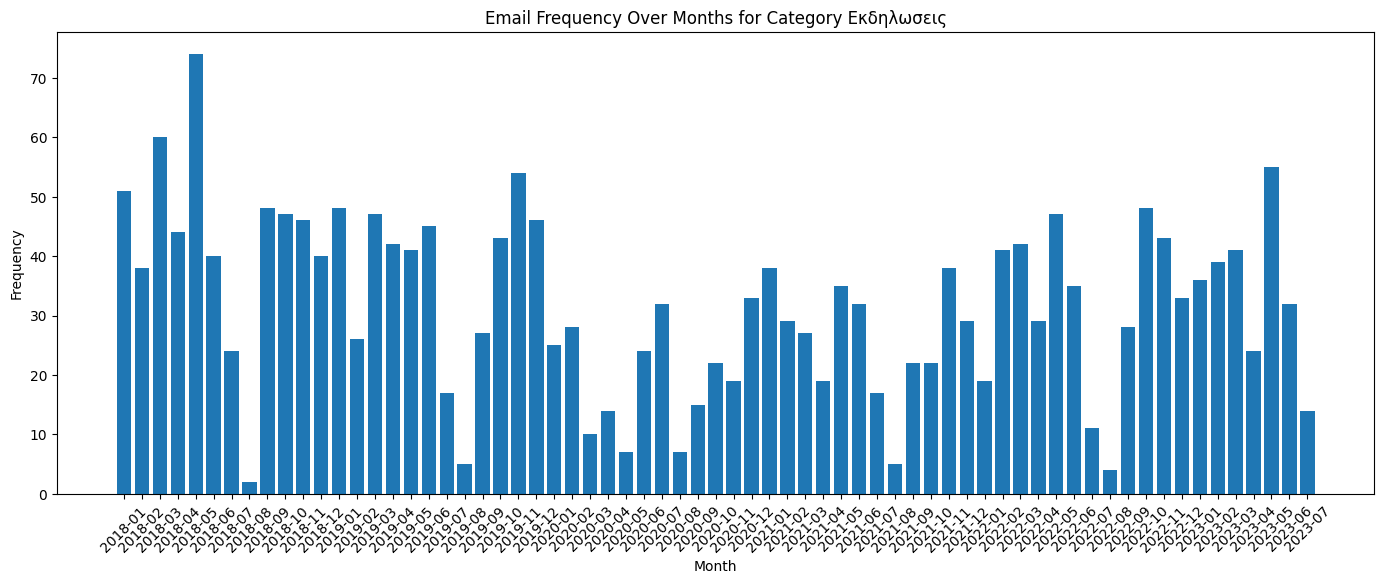

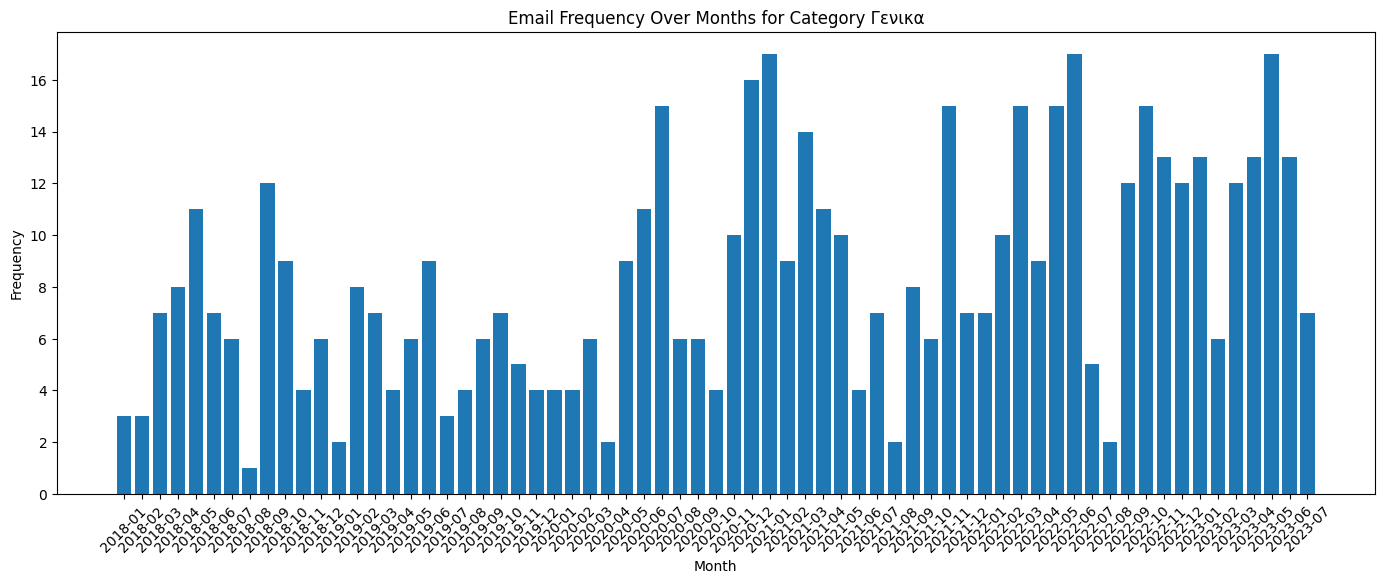

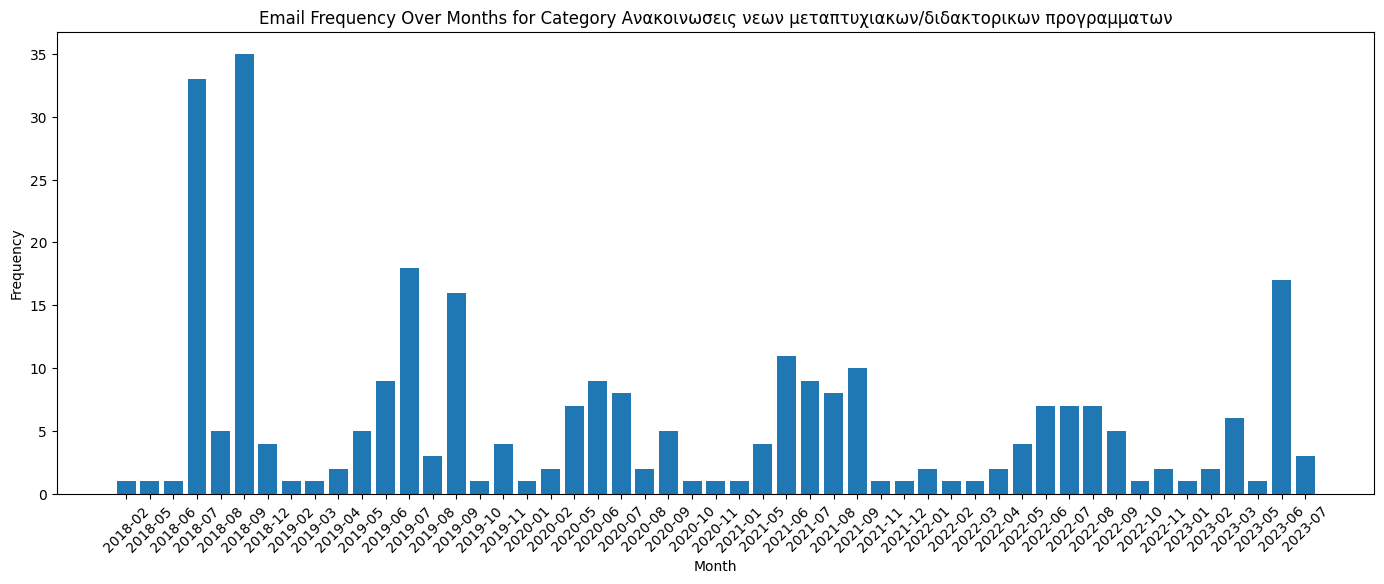

In [719]:
categories = df['Bert_Labels'].unique()
for category in categories:
    category_data = df[df['Bert_Labels'] == category]
    
    grouped = category_data.groupby('Month').size()
    
    plt.figure(figsize=(17, 6))
    plt.bar(grouped.index.astype(str), grouped.values)
    
    plt.title(f'Email Frequency Over Months for Category {category}')
    plt.xlabel('Month')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45) 
    
    plt.show()